# Titanic — EDA, cleaning, basic modeling
**Notebook:** `notebooks/titanic_eda_and_model.ipynb`  
**Author:** Swayam
**Date:** 10-08-2025

Goals:
- Load and inspect the Titanic dataset
- Clean missing values and create simple features
- Exploratory analysis with plots
- Train a baseline classifier (Logistic Regression) + Random Forest
- Save cleaned data and model


In [1]:
import os
from pathlib import Path

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, roc_auc_score
)
import joblib

In [25]:
BASE = Path.cwd().parent 
RAW = BASE / "data" / "raw"
PROC = BASE / "data" / "processed"
PROC.mkdir(parents=True, exist_ok=True)

train_path = RAW / "train.csv"
df = pd.read_csv(train_path)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [27]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

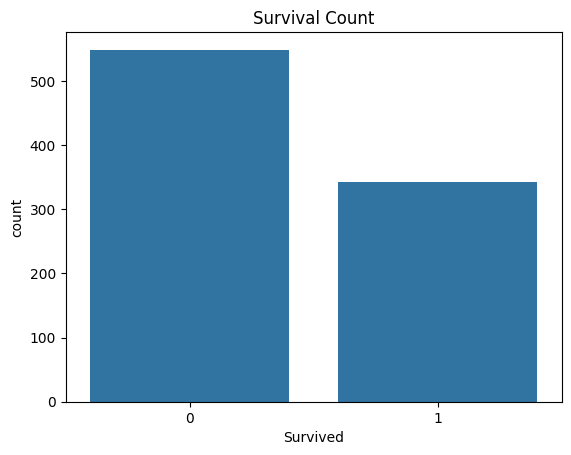

In [28]:
sns.countplot(x='Survived', data=df)
plt.title('Survival Count')
plt.show()

Text(0.5, 1.0, 'Age Distribution')

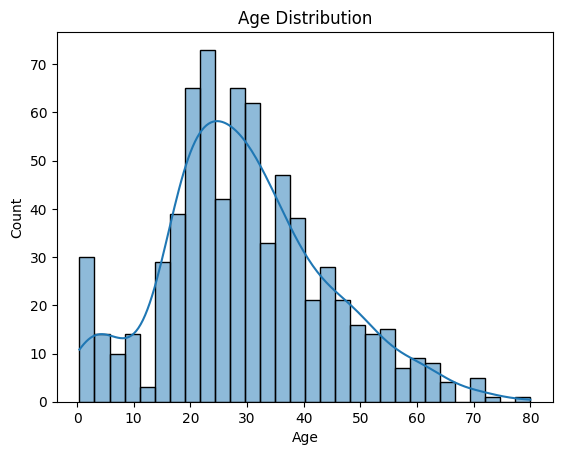

In [29]:
sns.histplot(df['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')

In [30]:
df2 = df.copy()
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1

df2['Embarked'] = df2['Embarked'].fillna(df2['Embarked'].mode()[0])

df2['CabinKnown'] = (~df2['Cabin'].isna()).astype(int)

df2['AgeBin'] = pd.cut(df2['Age'], bins=[0,12,20,40,60,120], labels=['child','teen','adult','mid','senior'])
df2.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinKnown,AgeBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,1,adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,1,adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,adult


In [31]:
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','FamilySize','CabinKnown']
target = 'Survived'

df_model = df2[features + [target]].copy()
df_model.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,CabinKnown,Survived
0,3,male,22.0,1,0,7.2500,S,2,0,0
1,1,female,38.0,1,0,71.2833,C,2,1,1
2,3,female,26.0,0,0,7.9250,S,1,0,1
3,1,female,35.0,1,0,53.1000,S,2,1,1
4,3,male,35.0,0,0,8.0500,S,1,0,0


In [32]:
X = df_model.drop(columns=[target])
y = df_model[target]

X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,CabinKnown
0,3,male,22.0,1,0,7.2500,S,2,0
1,1,female,38.0,1,0,71.2833,C,2,1
2,3,female,26.0,0,0,7.9250,S,1,0
3,1,female,35.0,1,0,53.1000,S,2,1
4,3,male,35.0,0,0,8.0500,S,1,0


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((712, 9), (179, 9))

In [34]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
cat_features = ['Pclass', 'Sex', 'Embarked', 'CabinKnown']

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [35]:
log_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=200))
])

log_pipe.fit(X_train, y_train)
y_pred = log_pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [36]:
rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

RF Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.71      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



In [37]:
from sklearn.model_selection import cross_val_score

for name, pipe in [('Logistic Regression', log_pipe), ('Random Forest', rf_pipe)]:
    scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
    print(name, 'CV accuracy:', scores.mean(), '+/-', scores.std())

Logistic Regression CV accuracy: 0.808072311844831 +/- 0.01934243608631235
Random Forest CV accuracy: 0.7980227229929069 +/- 0.03432791488241199


In [38]:
df2.to_csv(PROC / "titanic_train_cleaned.csv", index=False)

best_model = log_pipe
joblib.dump(best_model, PROC / "titanic_model_log.joblib")
print("Saved cleaned data and model to:", PROC)

Saved cleaned data and model to: c:\Users\nagar\ml-journey\phase1-foundations\data\processed
